## File 03 - Basic Preprocessed Data Output

In this file, we create a small preprocessed data table.

### Set up Spark session and data schema

We can specify more options in the SparkSession creator, but currently the options are at the default settings.

In [1]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql import types as T
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import log

import sys
spark = SparkSession.builder \
        .appName("project") \
        .getOrCreate()

sc = spark.sparkContext

schema = "`event_time` TIMESTAMP,`event_type` STRING,`product_id` INT,`category_id` BIGINT,`category_code` STRING,`brand` STRING,`price` FLOAT,`user_id` INT,`user_session` STRING"
ddl_schema = T._parse_datatype_string(schema)

CPU times: user 539 ms, sys: 325 ms, total: 865 ms
Wall time: 5.71 s


### Read in prefiltered train & test sets

In [2]:
%%time
train = spark.read.parquet("/project/ds5559/group12/raw_data/train_buyers.parquet")
test = spark.read.parquet("/project/ds5559/group12/raw_data/test_buyers.parquet")
full = train.union(test)

CPU times: user 5.57 ms, sys: 601 µs, total: 6.17 ms
Wall time: 3.16 s


In [3]:
train.select('user_id').distinct().count()

286853

In [4]:
test.select('user_id').distinct().count()

72252

### Get some descriptive statistics

In [5]:
full.count()

23561460

In [6]:
full.select('user_id').distinct().count()

359105

In [7]:
%%time
full.select('product_id').distinct().count()
# There are 220,463 different products. 

CPU times: user 2.42 ms, sys: 1.23 ms, total: 3.65 ms
Wall time: 2.37 s


220463

In [8]:
%%time
full.select('category_code').distinct().count()
# There are 139 different categories

CPU times: user 2.35 ms, sys: 294 µs, total: 2.64 ms
Wall time: 2.26 s


139

In [9]:
%%time
full.select('brand').distinct().count()
# There are 5135 different brands

CPU times: user 2 ms, sys: 1.71 ms, total: 3.71 ms
Wall time: 1.91 s


5135

In [10]:
events = full.groupBy('event_type').count()

In [11]:
events.show()

+----------+--------+
|event_type|   count|
+----------+--------+
|  purchase| 1285824|
|      view|19709697|
|      cart| 2565939|
+----------+--------+



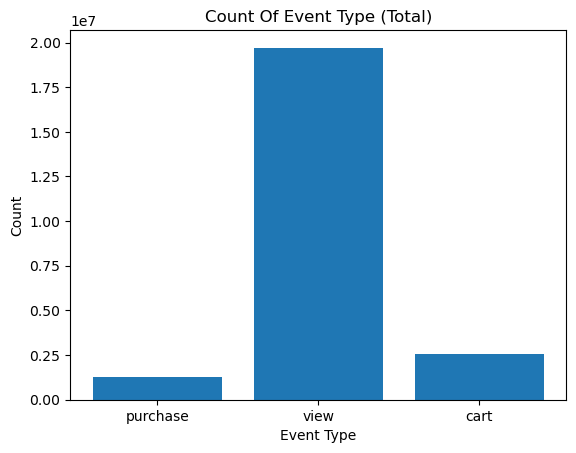

In [12]:
x = events.select('event_type').toPandas()['event_type']
y = events.select('count').toPandas()['count']

plt.bar(x, y)
plt.title("Count Of Event Type (Total)")
plt.xlabel("Event Type")
plt.ylabel("Count")


plt.show()

In [13]:
p1 = full.filter(full.Period == '1')
p2 = full.filter(full.Period == '2')

In [14]:
print(p1.count())
print(p2.count())

15923973
7637487


### Pivot Data

In [15]:
# Get the number of items purchased per person, per category
cats = p1.filter(p1.event_type == "purchase").groupBy('user_id').pivot('category_code').count()

In [16]:
cats.take(1)

[Row(user_id=512372691, null=1, accessories.bag=1, accessories.umbrella=None, accessories.wallet=None, apparel.belt=None, apparel.costume=None, apparel.dress=None, apparel.glove=None, apparel.jacket=None, apparel.jeans=None, apparel.jumper=None, apparel.pajamas=None, apparel.scarf=None, apparel.shirt=None, apparel.shoes=None, apparel.shoes.ballet_shoes=None, apparel.shoes.espadrilles=None, apparel.shoes.keds=None, apparel.shoes.moccasins=None, apparel.shoes.sandals=None, apparel.shoes.slipons=None, apparel.shoes.step_ins=None, apparel.shorts=None, apparel.skirt=None, apparel.sock=None, apparel.trousers=None, apparel.tshirt=None, apparel.underwear=None, appliances.environment.air_conditioner=None, appliances.environment.air_heater=None, appliances.environment.climate=None, appliances.environment.fan=None, appliances.environment.vacuum=None, appliances.environment.water_heater=None, appliances.iron=None, appliances.ironing_board=None, appliances.kitchen.blender=None, appliances.kitchen.c

### Create temp view

In [17]:
p1.createOrReplaceTempView("m1")
p2.createOrReplaceTempView('m2')
cats.createOrReplaceTempView('cats')

### Create a transformed table containing elements of interest for our model

We propose a basic table format (see https://docs.google.com/document/d/1NG4KGticBXn0D3PL5_zMxLV2Pr7A8PQtLcasxCOd1nA/edit).

Every row is a user_id who exists in M1 and may or may not exist in M2.
Columns include:
- `user_id` (ID)
- `m2_total_spend` (sum among all purchase events, NB: month 2. Will be 0 is user does not exist in month 2 or makes no purchase events)
- `m1_total_spend` (sum among all purchase events)
- `m1_user_sessions` (count of distinct user sessions/browsing sessions)
- `m1_purchase_events` (count of distinct purchase events)

Additional rows may have been added below.


In [18]:
%%time
df = spark.sql("""SELECT

               /* ID */
               m1.user_id AS user_id,
               
               /* Output: Total spend in month 2; Will be 0 is user does not exist in month 2 or makes no purchase events */
               IFNULL(SUM(m2.price),0) AS m2_total_spend,
               
               
               /* Total spend in month 1: we sum the price of any 'purchase' events */
               SUM(CAST(m1.event_type=='purchase' AS INT) * m1.price) AS m1_total_spend,
               
               /* Total events in month 1: includes all event types (multiple per session) */
               COUNT(m1.event_type) AS m1_total_events,
               
               /* Total purchase events in month 1: we sum the occurence of any 'purchase' events */
               SUM(CAST(m1.event_type=='purchase' AS INT)) AS m1_purchase_events,
               
               /* Total user sessions in month 1: we count all distinct user sessions */
               COUNT(DISTINCT m1.user_session) AS m1_user_sessions
               
               FROM m1
               
            LEFT JOIN 
            (
               SELECT * FROM m2
               WHERE event_type='purchase'
            ) m2
            
            ON m1.user_id=m2.user_id
            
            GROUP BY m1.user_id ORDER BY m1_purchase_events DESC""")
df.show(5)

+---------+--------------------+--------------------+---------------+------------------+----------------+
|  user_id|      m2_total_spend|      m1_total_spend|m1_total_events|m1_purchase_events|m1_user_sessions|
+---------+--------------------+--------------------+---------------+------------------+----------------+
|568782581|2.3885857005200386E8| 5.821735228239441E7|         926856|            227808|             532|
|563599039|2.3802253637968063E8| 6.886928014480591E7|         442758|            133743|             108|
|549109608|1.8224688173866272E8| 5.723722944006348E7|         343000|             88151|             132|
|513230794|2.0587978875039673E8| 4.171333637634277E7|         412115|             85845|              33|
|582826305|1.9694101198085403E8|1.7104022296691895E7|         605784|             61404|             123|
+---------+--------------------+--------------------+---------------+------------------+----------------+
only showing top 5 rows

CPU times: user 1.73 

In [19]:
#%%time
#df.write.parquet("/project/ds5559/group12/raw_data/some_features.parquet")

+---------+-------------------+----------+----------+-------------------+--------------------+---------+------+--------------------+------+
|  user_id|         event_time|event_type|product_id|        category_id|       category_code|    brand| price|        user_session|Period|
+---------+-------------------+----------+----------+-------------------+--------------------+---------+------+--------------------+------+
|512394150|2020-01-02 17:14:25|      view|  10503781|2053013553199186187|                null|   hasbro|  9.76|be0067d2-8d0e-410...|     1|
|512394150|2020-01-02 17:15:02|      view|  10503781|2053013553199186187|                null|   hasbro|  9.76|3e12276c-bafa-4de...|     1|
|512394150|2020-01-02 17:15:18|      view|  10503781|2053013553199186187|                null|   hasbro|  9.76|ae5a0c6e-4cde-4b6...|     1|
|512394150|2020-01-02 17:15:36|      view|  10503781|2053013553199186187|                null|   hasbro|  9.76|61ca5b0c-b6e5-42f...|     1|
|512394150|2020-01-0

In [26]:
test.show()

+---------+-------------------+----------+----------+-------------------+--------------------+------+------+--------------------+------+
|  user_id|         event_time|event_type|product_id|        category_id|       category_code| brand| price|        user_session|Period|
+---------+-------------------+----------+----------+-------------------+--------------------+------+------+--------------------+------+
|512439971|2020-01-02 14:32:40|      view|   1005217|2232732093077520756|construction.tool...|xiaomi|141.29|bee3f956-a5f0-4d8...|     1|
|512439971|2020-01-02 14:33:08|      view|   1005217|2232732093077520756|construction.tool...|xiaomi|141.29|bee3f956-a5f0-4d8...|     1|
|512439971|2020-01-03 06:22:51|      view|  12400291|2232732092087664982|electronics.audio...| total| 51.46|638b743b-342b-4dc...|     1|
|512439971|2020-01-03 06:23:08|      view|  12400291|2232732092087664982|electronics.audio...| total| 51.46|638b743b-342b-4dc...|     1|
|512439971|2020-01-03 06:29:05|      view

In [32]:
training = df.join(test, 'user_id', 'leftanti')
print(training.count())
training.show()

286853
+---------+--------------------+--------------------+---------------+------------------+----------------+
|  user_id|      m2_total_spend|      m1_total_spend|m1_total_events|m1_purchase_events|m1_user_sessions|
+---------+--------------------+--------------------+---------------+------------------+----------------+
|563599039|2.3802253637968063E8| 6.886928014480591E7|         442758|            133743|             108|
|549109608|1.8224688173866272E8| 5.723722944006348E7|         343000|             88151|             132|
|598224683| 1.575333588699646E8|2.9562396529960632E7|         270300|             58650|             156|
|572994775| 8.175372574493408E7| 1.597179462664032E7|         278478|             52731|             169|
|513320236|1.1508168612892914E8|2.2369278694839478E7|         217890|             48330|              65|
|602281209| 1.238869539738617E8|1.9945883200683594E7|         204320|             39040|             149|
|601324663| 8.580432808032227E7|1.09224

In [33]:
testing = df.join(train, 'user_id', 'leftanti')
print(testing.count())
testing.show()

72252
+---------+--------------------+--------------------+---------------+------------------+----------------+
|  user_id|      m2_total_spend|      m1_total_spend|m1_total_events|m1_purchase_events|m1_user_sessions|
+---------+--------------------+--------------------+---------------+------------------+----------------+
|568782581|2.3885857005200386E8| 5.821735228239441E7|         926856|            227808|             532|
|513230794|2.0587978875039673E8| 4.171333637634277E7|         412115|             85845|              33|
|582826305|1.9694101198085403E8|1.7104022296691895E7|         605784|             61404|             123|
|566448225| 8.611105072402954E7|    8298110.25957489|         335820|             28950|             331|
|521025518| 5.805999201248169E7|1.1752005871582031E7|         142590|             28809|              54|
|597278112|  4.95544200963974E7| 1.009350573943615E7|         134000|             24254|             169|
|580880864| 2.891635742661667E7|  197969

In [34]:
%%time
training.write.parquet("/project/ds5559/group12/raw_data/train_reshaped.parquet")

CPU times: user 3.26 ms, sys: 1.87 ms, total: 5.13 ms
Wall time: 15.1 s


In [35]:
%%time
testing.write.parquet("/project/ds5559/group12/raw_data/test_reshaped.parquet")

CPU times: user 2.77 ms, sys: 1.22 ms, total: 3.99 ms
Wall time: 11.7 s


In [31]:
training.count()

72252

In [18]:
cat_codes_plus = df.join(cats, df.user_id == cats.user_id, "fullouter")

In [19]:
%%time
cat_codes_plus.count()

CPU times: user 2.41 ms, sys: 1.11 ms, total: 3.52 ms
Wall time: 7.78 s


359105

In [20]:
%%time
user_sessions = cat_codes_plus.select('m1_user_sessions').toPandas()

CPU times: user 1.48 s, sys: 91.5 ms, total: 1.57 s
Wall time: 10.5 s


In [21]:
cat_codes_plus.describe('m1_user_sessions').show()

+-------+-----------------+
|summary| m1_user_sessions|
+-------+-----------------+
|  count|           359105|
|   mean|7.512850002088526|
| stddev| 24.2115288468888|
|    min|                1|
|    max|             9149|
+-------+-----------------+



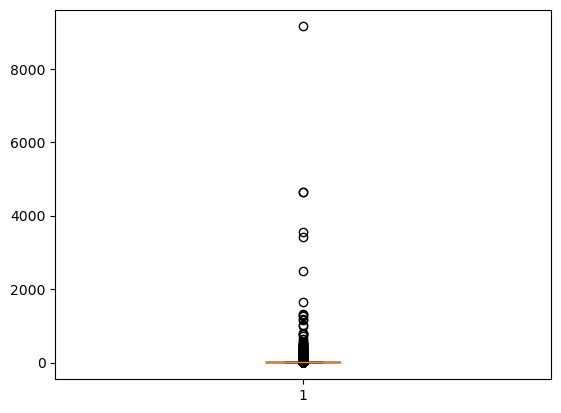

CPU times: user 158 ms, sys: 10.5 ms, total: 169 ms
Wall time: 167 ms


In [22]:
%%time
plt.boxplot(user_sessions)
plt.show()

In [23]:
mean = 7.512850002088526
std = 24.2115288468888
cutoff = mean + 3*std

## Let's remove outliers and retry this

In [24]:
#https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
for i in ["m1_user_sessions"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    ccp = pipeline.fit(cat_codes_plus).transform(cat_codes_plus).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")


In [25]:
ccp.select("m1_user_sessions_Scaled").show()

+-----------------------+
|m1_user_sessions_Scaled|
+-----------------------+
|                    0.0|
|                  0.001|
|                  0.001|
|                  0.001|
|                  0.001|
|                    0.0|
|                    0.0|
|                  0.001|
|                  0.002|
|                  0.004|
|                    0.0|
|                  0.002|
|                  0.001|
|                  0.005|
|                  0.001|
|                  0.001|
|                  0.001|
|                  0.004|
|                    0.0|
|                  0.002|
+-----------------------+
only showing top 20 rows



In [26]:
ccp.describe('m1_user_sessions_Scaled').show()

+-------+-----------------------+
|summary|m1_user_sessions_Scaled|
+-------+-----------------------+
|  count|                 359105|
|   mean|   6.641762158700039E-4|
| stddev|   0.002671847744529227|
|    min|                    0.0|
|    max|                    1.0|
+-------+-----------------------+



In [27]:
# That's a pain in the ass. Going to drop extreme outliers (>3x standard deviation)

In [28]:
cat_codes_plus.createOrReplaceTempView('cats')

In [29]:
print(cutoff)

80.14743654275493


In [30]:
%%time
df = spark.sql("""SELECT * FROM cats
               WHERE m1_user_sessions <= 80
               """)

CPU times: user 1.09 ms, sys: 30 µs, total: 1.12 ms
Wall time: 27.5 ms


In [31]:
%%time
df.count() # It looks like doing that wound up dropping 

CPU times: user 2.8 ms, sys: 687 µs, total: 3.49 ms
Wall time: 8.37 s


358410

In [32]:
359105-348410 #We dropped this many extreme outliers - given their frequent purchases, 
#I'd say they were all shoe-ins for purchase the next month, but they'd make it suuper difficult to model accurately

10695

In [33]:
%%time
df.describe('m1_user_sessions').show()

+-------+-----------------+
|summary| m1_user_sessions|
+-------+-----------------+
|  count|           358410|
|   mean|7.171153148628665|
| stddev|8.377241229441916|
|    min|                1|
|    max|               80|
+-------+-----------------+

CPU times: user 3.7 ms, sys: 1.03 ms, total: 4.73 ms
Wall time: 8.48 s


In [34]:
user_sessions_filtered = df.select("m1_user_sessions").toPandas()

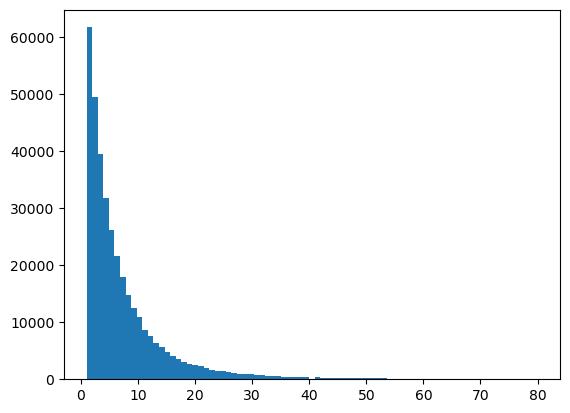

In [35]:
n_bins = 81

plt.hist(user_sessions_filtered, bins=n_bins)
plt.show() 

Looking at this... I think we could prune outliers again if we want. It's already not 'proper' because this isn't normally distributed. We're just trying to get the crazy cases to go away. 

In [36]:
ccp_ln = ccp.withColumn('log_m1_user_sessions', log(ccp['m1_user_sessions']))

In [37]:
ccp_ln.select('m1_user_sessions', 'log_m1_user_sessions').show(5)

+----------------+--------------------+
|m1_user_sessions|log_m1_user_sessions|
+----------------+--------------------+
|               3|  1.0986122886681096|
|              11|  2.3978952727983707|
|              11|  2.3978952727983707|
|               7|  1.9459101490553132|
|               7|  1.9459101490553132|
+----------------+--------------------+
only showing top 5 rows



In [38]:
user_sessions_log = ccp_ln.select("log_m1_user_sessions").toPandas()

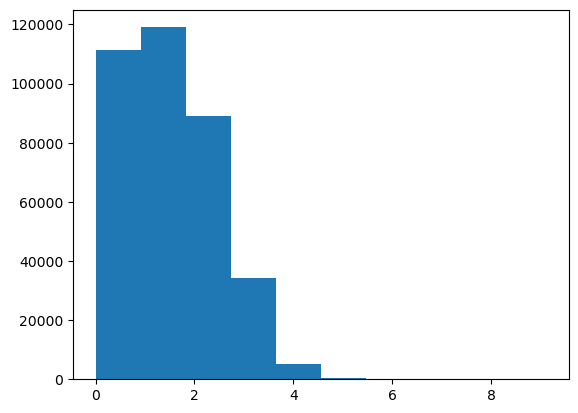

In [39]:
plt.hist(user_sessions_log)
plt.show()

AnalysisException: Found duplicate column(s) when inserting into file:/project/ds5559/group12/raw_data/some_features.parquet: `user_id`

In [42]:
ccp_ln.show(1)

+---------+------------------+------------------+---------------+------------------+----------------+---------+----+---------------+--------------------+------------------+------------+---------------+-------------+-------------+--------------+-------------+--------------+---------------+-------------+-------------+-------------+--------------------------+-------------------------+------------------+-----------------------+---------------------+---------------------+----------------------+--------------+-------------+------------+----------------+--------------+-----------------+--------------------------------------+---------------------------------+------------------------------+--------------------------+-----------------------------+-----------------------------------+---------------+------------------------+--------------------------+---------------------------------+---------------------------------+-----------------------------+------------------------+------------------------+-